In [7]:
import os
from dotenv import load_dotenv
from openai import OpenAI  

In [8]:
import os
os.chdir("/Users/fuaisonfuaison/Desktop/Agent")
print("Now in:", os.getcwd())


Now in: /Users/fuaisonfuaison/Desktop/Agent


In [9]:
load_dotenv()

True

In [10]:
from langchain_openai import ChatOpenAI 

In [11]:
llm = ChatOpenAI(model="gpt-4o") 

In [16]:
from typing import Annotated,List
from pydantic import BaseModel,Field
import operator


class Section(BaseModel):
    name: str = Field(
        description ='Nmae for the section of report.',
        
    )
    description: str = Field(
        description ='Brief overview of the main topics and concepts to be covered in this section.'
    )

class Sections(BaseModel):
    section:List[Section] = Field(
        description ='Sections of the report.'
    )

planner = llm.with_structured_output(Sections)

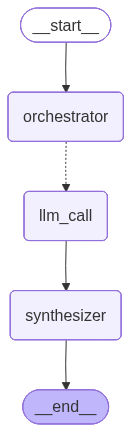

## Introduction
Agentic AI refers to artificial intelligence systems designed to operate autonomously, making decisions and taking actions without human intervention. Its purpose is to enhance efficiency, adaptability, and innovation across various sectors. In today's technological landscape, Agentic AI holds significant potential for transforming industries, from healthcare to finance. However, understanding the challenges it faces, such as ethical considerations, accountability, and control, is crucial. Addressing these issues is essential to harnessing its full potential while ensuring responsible and safe deployment.

---

## Technological Challenges
Developing Agentic AI faces several technical hurdles. Computational limitations pose significant challenges, as these systems require immense processing power to function effectively. Additionally, the vast data processing requirements necessitate advanced algorithms capable of handling and analyzing large datasets efficiently. Creating autonomous decision-making systems adds complexity, as it involves designing AI that can make independent, context-aware decisions while ensuring safety and ethical considerations. Balancing these factors is crucial to advancing Agentic AI technology.

---

## Ethical and Moral Challenges
Agentic AI presents significant ethical dilemmas, primarily concerning accountability, transparency, and bias. Accountability issues arise when AI systems make decisions without clear responsibility, complicating liability in adverse outcomes. Transparency is crucial, yet often lacking, as AI's decision-making processes can be opaque, making it difficult for users to understand or challenge outcomes. Additionally, AI systems may perpetuate or even exacerbate existing biases, leading to unfair or discriminatory decisions. Addressing these challenges requires robust frameworks to ensure AI systems are designed and deployed ethically, with mechanisms for oversight and redress to maintain public trust and fairness.

---

## Regulatory and Legal Challenges
The regulatory landscape for Agentic AI is evolving, with existing laws often lagging behind technological advancements. Current regulations may not fully address the unique challenges posed by AI, leading to potential legal liabilities. There is a growing need for new regulations to manage issues such as accountability, transparency, and ethical use. Policymakers are urged to develop frameworks that ensure AI systems are safe, fair, and aligned with societal values, while also fostering innovation. As AI continues to advance, ongoing dialogue between stakeholders is essential to adapt legal frameworks to emerging challenges.

---

## Social and Cultural Challenges
Agentic AI presents significant societal impacts, including public perception challenges, cultural resistance, and potential job displacement. Public perception often oscillates between fascination and fear, influenced by media portrayals and ethical concerns. Cultural resistance arises from apprehensions about AI's role in altering traditional practices and values. Additionally, the potential for job displacement poses economic disruptions, as AI could replace certain roles, necessitating workforce adaptation and reskilling. Addressing these challenges requires transparent communication, inclusive policy-making, and proactive strategies to mitigate economic impacts, ensuring AI's integration benefits society equitably.

---

## Security Challenges
Agentic AI poses significant security risks, including vulnerability to hacking, where malicious actors could manipulate AI systems for unauthorized purposes. Misuse of AI can lead to unethical applications, such as surveillance or autonomous weaponry. Additionally, AI systems making critical decisions without human oversight can result in unintended consequences, potentially causing harm or violating privacy. Ensuring robust security measures and ethical guidelines is crucial to mitigate these risks and safeguard against potential threats associated with Agentic AI.

---

## Case Studies
Explore real-world applications of Agentic AI through case studies that reveal both successes and challenges. These examples highlight lessons learned and best practices, offering insights into effective implementation. Key challenges include ethical considerations, data privacy, and integration with existing systems. Successful applications demonstrate the importance of clear objectives, stakeholder collaboration, and continuous monitoring. By examining these case studies, organizations can better navigate the complexities of deploying Agentic AI, ensuring responsible and efficient use.

---

## Future Outlook
Agentic AI is poised for significant advancements, with technology evolving towards more autonomous and intelligent systems. Future developments may include enhanced decision-making capabilities and improved human-AI collaboration. Ethical standards will likely evolve to address concerns about privacy, bias, and accountability, necessitating robust frameworks. International cooperation will be crucial in harmonizing regulations and addressing global challenges, ensuring AI benefits are equitably distributed. Collaborative efforts can foster innovation while mitigating risks, promoting a balanced approach to AI development.

---

## Conclusion
In conclusion, the report highlights the critical challenges in developing and deploying Agentic AI responsibly. Key points include the need for robust ethical frameworks, transparency in AI decision-making, and ensuring AI systems align with human values. Addressing these challenges is essential to mitigate risks and harness AI's potential for societal benefit. Prioritizing collaboration among stakeholders, continuous monitoring, and adaptive governance will be crucial in navigating the complexities of Agentic AI. By focusing on these areas, we can foster trust and ensure AI technologies contribute positively to society.

In [31]:
# --- imports / setup ---
from typing import Annotated, List
import operator
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image, display, Markdown
from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(model="gpt-4o", temperature=0,max_tokens=500)

# ---- planner schema (orchestrator will use this) ----
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report")
    description: str = Field(description="What that section should cover")

class Sections(BaseModel):
    sections: List[Section] = Field(description="Brief overview of the main topics and concepts to be covered in this section.")

planner = llm.with_structured_output(Sections)

# ---- graph state ----
class State(TypedDict):
    topic: str
    sections: List[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str

# worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# ---- nodes ----
def orchestrator(state: State):
    """Plan sections for the report."""
    plan = planner.invoke([
        SystemMessage(content="Generate a plan for the report."),
        HumanMessage(content=f"Document to summarize:\n{state['topic']}"),
    ])
    return {"sections": plan.sections}

def llm_call(state: WorkerState):
    """Worker writes one section."""
    sec = state["section"]
    msg = llm.invoke([
        SystemMessage(content="Write this section concisely, within ~100 words. Use markdown formatting. Do NOT include the section title."),
        HumanMessage(content=f"Section name: {sec.name}\nSection focus: {sec.description}\n\nDocument:\n{state.get('topic','')}"),
    ])
    # include a header so synthesizer is readable
    return {"completed_sections": [f"## {sec.name}\n{msg.content.strip()}"]}

def synthesizer(state: State):
    """Combine all sections."""
    body = "\n\n---\n\n".join(state["completed_sections"])
    return {"final_report": body}

def assign_workers(state: State):
    """Create a worker job per planned section."""
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

# ---- build graph ----
builder = StateGraph(State)
builder.add_node("orchestrator", orchestrator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesizer", synthesizer)

builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
builder.add_edge("llm_call", "synthesizer")
builder.add_edge("synthesizer", END)

orchestrator_worker = builder.compile()

# visualize
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# run
state = orchestrator_worker.invoke({"topic": "Create a report on current challenge for  Agentic AI"})
Markdown(state["final_report"])
